In [1]:
# Imports generales
import pandas as pd
import io
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import cluster
import sklearn.metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import kneighbors_graph
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.metrics import davies_bouldin_score



In [2]:
path = 'D:/Usuario/Documentos/000.Trabajo_Fin_Master/Bases_datos/'

In [3]:
base = pd.read_excel(path + 'Base_ppal.xlsx')
mpios = pd.read_excel( path + 'DNP mpios2025 base mpios.xlsx', sheet_name = 'Municipios')
mpios

,MPIO,Municipio,Tipología_2025,Ciudad_capital,CAT_ruralidad 2023
0,5360,ITAGÜÍ,1,0,Ciudades y aglomeraciones
1,5001,MEDELLÍN,Ciudades grandes,1,Ciudades y aglomeraciones
2,8758,SOLEDAD,1,0,Ciudades y aglomeraciones
3,8001,BARRANQUILLA,Ciudades grandes,1,Ciudades y aglomeraciones
4,5631,SABANETA,1,0,Ciudades y aglomeraciones
...,...,...,...,...,...
1097,18756,SOLANO,5,0,Rural disperso
1098,88564,PROVIDENCIA,4,0,Intermedio
1099,91001,LETICIA,5,1,Rural
1100,91540,PUERTO NARIÑO,5,0,Rural disperso


In [4]:
base = base.merge(mpios, on = 'MPIO', how = 'left')

In [5]:
base['MUNICIPIO_ANIO'] = base['MPIO'].astype(str) + '_' + base['ANIO_DES'].astype(str)

## Definicion función de métricas

In [6]:
def md_search(modelo,predecir, tipo_modelo):
    
    # cluster the data into five clusters
    model = modelo
    clusters = model.fit_predict(predecir)


    sil_score = silhouette_score(predecir, clusters)
    print("Silhouette Score:", sil_score)


    ch_score = calinski_harabasz_score(predecir, clusters)
    print("Calinski-Harabasz Index:", ch_score)


    db_score = davies_bouldin_score(predecir, clusters)
    print("Davies-Bouldin Index:", db_score)


    metricas = pd.DataFrame({
        'Silhouette': [sil_score],
        'Calinski-Harabasz': [ch_score],
        'Davies-Bouldin': [db_score]
    })

    metricas.set_index([[tipo_modelo]])
    return metricas

In [7]:
mpios_des = base.groupby(['MUNICIPIO_ANIO', 'CLASIFICACION', 'CAT_ruralidad 2023', 'Tipología_2025', 'Ciudad_capital'])['EDAD_QUINQ'].count().reset_index()

In [8]:
df_pivot = mpios_des.pivot_table(
    index=['MUNICIPIO_ANIO', 'CAT_ruralidad 2023', 'Tipología_2025', 'Ciudad_capital'],
    columns='CLASIFICACION',
    values='EDAD_QUINQ',
    fill_value=0  # Opcional: para poner 0 si no hay datos
).reset_index()


In [9]:
nombres = ['MUNICIPIO_ANIO', 'CAT_ruralidad 2023', 'Tipologia_2025',
       'Ciudad_capital', 'Des_Forzada',
       'Sin_Info']

df_pivot.columns = nombres

df_pivot['Tipologia_2025'] = df_pivot['Tipologia_2025'].astype(str) 

In [10]:
print(df_pivot['CAT_ruralidad 2023'].unique())
print(df_pivot['Tipologia_2025'].unique())

['Ciudades y aglomeraciones' 'Rural disperso' 'Rural' 'Intermedio']
['Bogotá' 'Ciudades grandes' '5' '2' '4' '3' '1'
 'SC- Centro aglomeración\n']


In [12]:
df_pivot["CAT_ruralidad 2023"].nunique()

4

## K Means

Convertiré todas las variables a numéricas a ver si obtengo mejores resultados.

No es lo correcto, pero de cierta manera las cualitativas guardan una ordinalidad, por ende, La interpretación en K medias podría ser acertada.

In [11]:
['Ciudades y aglomeraciones' 'Rural disperso' 'Rural' 'Intermedio']

reemplazos = { 
              'Ciudades y aglomeraciones': 4,
              'Intermedio': 3,
              'Rural disperso': 2,
              'Rural': 1,}

df_pivot['CAT_ruralidad 2023'] = df_pivot['CAT_ruralidad 2023'].replace(reemplazos)


reemplazos = { 
              'Bogotá': 8,
              'Ciudades grandes': 7,
              'SC- Centro aglomeración\n': 6,
              '5': 5,
              '4': 4,
              '3': 3,
              '2': 2,
              '1': 1}

df_pivot['Tipologia_2025'] = df_pivot['Tipologia_2025'].replace(reemplazos)



C:\Users\juan.bonilla\AppData\Local\Temp\ipykernel_16000\2647900310.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot['CAT_ruralidad 2023'] = df_pivot['CAT_ruralidad 2023'].replace(reemplazos)
C:\Users\juan.bonilla\AppData\Local\Temp\ipykernel_16000\2647900310.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivot['Tipologia_2025'] = df_pivot['Tipologia_2025'].replace(reemplazos)


In [12]:
df_pivot_ciud_ppal = df_pivot[df_pivot['Tipologia_2025'] >= 7]
df_pivot_resto = df_pivot[df_pivot['Tipologia_2025'] < 7]

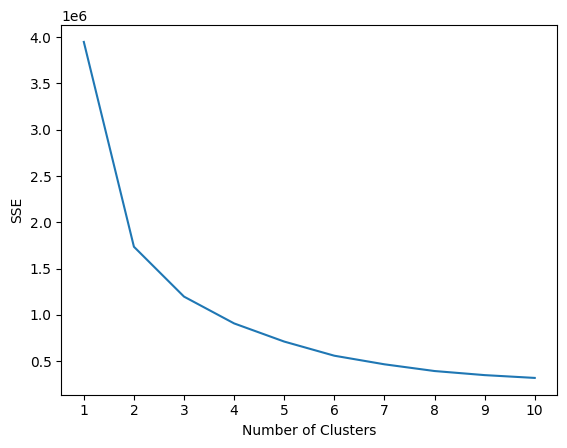

In [13]:
from sklearn.cluster import KMeans

train_kmeans = df_pivot_resto.drop(columns='cluster', errors='ignore')  # elimina la columna si existe
train_kmeans = train_kmeans.set_index('MUNICIPIO_ANIO')

#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(train_kmeans)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [14]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters=6, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(train_kmeans)

#view cluster assignments for each observation
kmeans.labels_

array([3, 3, 3, ..., 3, 3, 3], shape=(19429,), dtype=int32)

In [15]:
metricas_kmeans = md_search(kmeans,train_kmeans,"K-medias")

Silhouette Score: 0.7496581348251662
Calinski-Harabasz Index: 23610.11673864453
Davies-Bouldin Index: 0.6475304536139747


## Análisis de componentes principales

Para K medias

In [21]:
df_pivot['Ciudad_capital'] = df_pivot['Ciudad_capital'].astype(str)
df_pivot['CAT_ruralidad 2023'] = df_pivot['CAT_ruralidad 2023'].astype(str)
df_pivot['Tipologia_2025'] = df_pivot['Tipologia_2025'].astype(str)

df_pivot.set_index('MUNICIPIO_ANIO',inplace=True)

In [13]:
df_pivot

,MUNICIPIO_ANIO,CAT_ruralidad 2023,Tipologia_2025,Ciudad_capital,Des_Forzada,Sin_Info
0,11001_1948,Ciudades y aglomeraciones,Bogotá,1.0,0.0,1.0
1,11001_1949,Ciudades y aglomeraciones,Bogotá,1.0,0.0,1.0
2,11001_1951,Ciudades y aglomeraciones,Bogotá,1.0,0.0,1.0
3,11001_1954,Ciudades y aglomeraciones,Bogotá,1.0,0.0,1.0
4,11001_1955,Ciudades y aglomeraciones,Bogotá,1.0,1.0,1.0
...,...,...,...,...,...,...
19770,99773_2016,Rural disperso,5,0.0,2.0,1.0
19771,99773_2018,Rural disperso,5,0.0,0.0,2.0
19772,99773_2021,Rural disperso,5,0.0,1.0,0.0
19773,99773_2023,Rural disperso,5,0.0,1.0,0.0


In [14]:
from prince import FAMD

# Suponiendo que `df` es tu DataFrame original (mixto)
model = FAMD(n_components=5, random_state=42)
model = model.fit(df_pivot)

# Obtener componentes principales
df_famd = model.transform(df_pivot)


MemoryError: Unable to allocate 46.7 GiB for an array with shape (19775, 19790) and data type <U32

In [ ]:
model.cumulative_percentage_of_variance_

array([17.61720331, 31.11374887, 41.95122734, 51.93064107, 61.01621885])

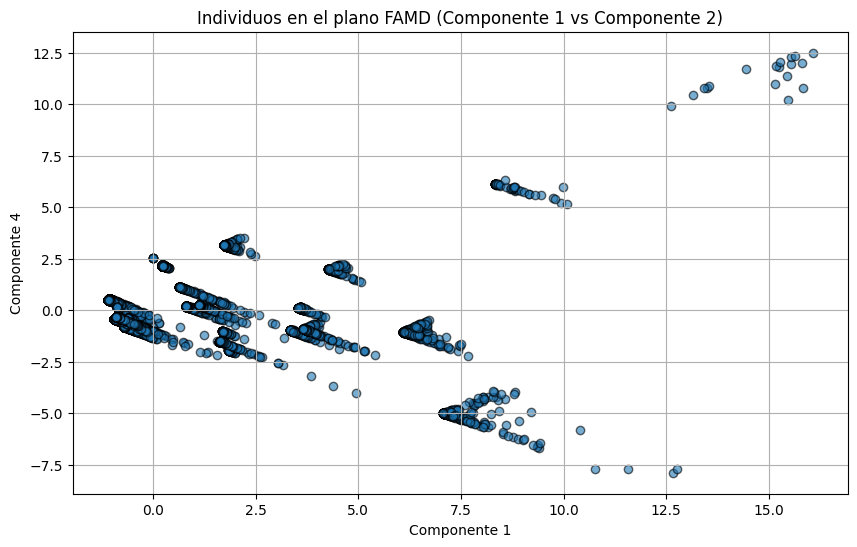

In [51]:
import matplotlib.pyplot as plt

# Scatter plot de las observaciones (individuos)
plt.figure(figsize=(10, 6))
plt.scatter(df_famd[0], df_famd[4], alpha=0.6, edgecolor='k')
plt.xlabel('Componente 1')
plt.ylabel('Componente 4')
plt.title('Individuos en el plano FAMD (Componente 1 vs Componente 2)')
plt.grid(True)
plt.show()


In [53]:
df_famd.to_csv(path + 'FAMD_municipios.csv', sep = ';')